Epoch 1/10


/var/folders/jt/6cptnf497m1b19p6ksf_gz6c0000gn/T/ipykernel_56585/3503065513.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')
/var/folders/jt/6cptnf497m1b19p6ksf_gz6c0000gn/T/ipykernel_56585/3503065513.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train_selected = stock_data[selected_features].fillna(method='ffill').fillna(method='bfill')


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2854
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0290
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0182
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0085
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0057
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0048
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━

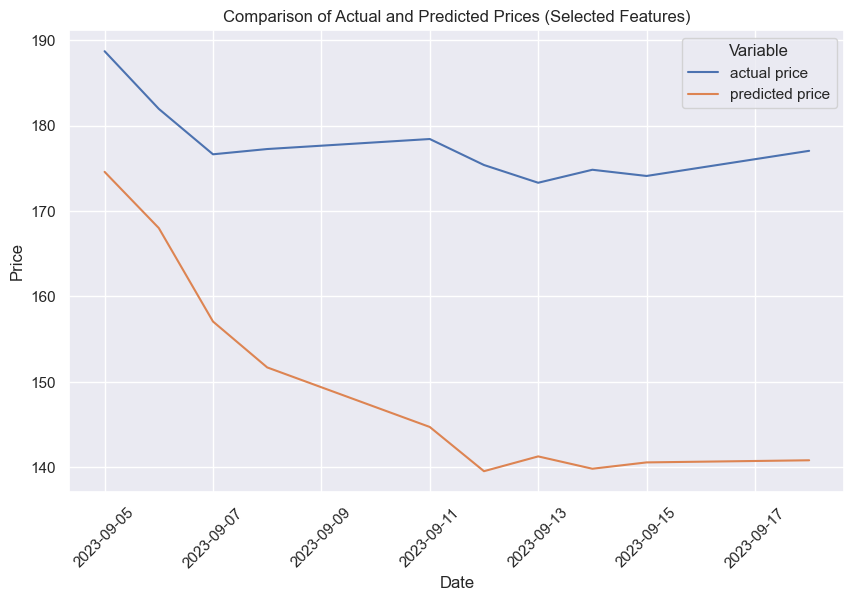

RMSE (Selected Features): 29.243052297535197


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from math import sqrt
from sklearn.metrics import mean_squared_error
import shap
from lime import lime_tabular

# Load the data
data = pd.read_csv('../data/stock_data_AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])
cutoff_date = '2023-09-01'
cutoff_date = pd.to_datetime(cutoff_date)
stock_data = data[data['Date'] <= cutoff_date]
future_data = data[data['Date'] > cutoff_date]
target = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')

# Selected features
selected_features = ['SMA_50', 'SMA_200', 'msft', 'MACD_signal', 'vix', 'Volume']  # Example selected features

# Fill NaN in selected features
X_train_selected = stock_data[selected_features].fillna(method='ffill').fillna(method='bfill')

# Scaling the features and target
scaler_selected = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_selected_features = scaler_selected.fit_transform(X_train_selected)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Time step
time_step = 120  # Number of timesteps (60 days lookback)
X_train_selected_seq, y_train_selected = [], []
for i in range(time_step, len(scaled_selected_features)):
    X_train_selected_seq.append(scaled_selected_features[i-time_step:i])
    y_train_selected.append(scaled_target[i])

X_train_selected_seq = np.array(X_train_selected_seq, dtype=np.float32)
y_train_selected = np.array(y_train_selected, dtype=np.float32)

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer model
def build_transformer_model(input_shape, num_heads=4, ff_dim=64):
    inputs = Input(shape=input_shape)
    transformer_block = TransformerBlock(embed_dim=input_shape[1], num_heads=num_heads, ff_dim=ff_dim)
    x = transformer_block(inputs, training=True)  # Make sure to pass training=True during model construction
    x = Flatten()(x)  # Flatten for dense output
    x = Dense(25, activation="relu")(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Input shape for the selected features model
input_shape_selected = (X_train_selected_seq.shape[1], X_train_selected_seq.shape[2])
transformer_model_selected = build_transformer_model(input_shape=input_shape_selected)
transformer_model_selected.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model using selected features
transformer_model_selected.fit(X_train_selected_seq, y_train_selected, batch_size=32, epochs=10)

# Predicting future prices
X_recent_selected = scaled_selected_features[-time_step:]  # Most recent 60 days for prediction
X_recent_selected = X_recent_selected.reshape(1, time_step, X_recent_selected.shape[1])

predicted_prices_selected_scaled = []
predicted_price_selected = transformer_model_selected.predict(X_recent_selected)[0][0]
predicted_prices_selected_scaled.append(predicted_price_selected)

days_to_predict = 10  # Predict next 9 days
for i in range(days_to_predict - 1):
    predicted_price_replicated_selected = np.full((1, 1, X_recent_selected.shape[2]), predicted_price_selected)
    X_recent_selected = np.append(X_recent_selected[:, 1:, :], predicted_price_replicated_selected, axis=1)
    predicted_price_selected = transformer_model_selected.predict(X_recent_selected)[0][0]
    predicted_prices_selected_scaled.append(predicted_price_selected)

# Inverse transform the predicted prices
predicted_prices_selected = scaler_target.inverse_transform(np.array(predicted_prices_selected_scaled).reshape(-1, 1))

# Get actual prices for comparison
actual_prices = future_data['Adj Close'][:days_to_predict].values
dates = future_data['Date'][:days_to_predict]

# Create a dataframe to compare actual and predicted prices using selected features
data_selected = pd.DataFrame({
    'Date': dates,
    'actual price': actual_prices,
    'predicted price': predicted_prices_selected.flatten()
})

# Reshape data for plotting
data_long_selected = pd.melt(data_selected, id_vars=['Date'], value_vars=['actual price', 'predicted price'], var_name='Variable', value_name='Value')

# Plot comparison of actual and predicted prices over time (selected features)
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_long_selected, x='Date', y='Value', hue='Variable')
plt.title('Comparison of Actual and Predicted Prices (Selected Features)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# RMSE calculation for selected features
rmse_selected = sqrt(mean_squared_error(data_selected['actual price'], data_selected['predicted price']))
print(f'RMSE (Selected Features): {rmse_selected}')